# Magic Carpet - Andre

In [ ]:
!pip install scikit_posthocs

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# display all pandas columns
pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")  # Setting the style of the background to a white grid for better readability



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
%pwd

'/content/drive/MyDrive/Colab_Notebooks/MagicCarpet'

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/MagicCarpet/Andre/

/content/drive/MyDrive/Colab_Notebooks/MagicCarpet/Andre


## Data Processing

#### Aux Functions

In [ ]:
def compute_path_length( df, technique ):

  # Calculate time differences
  df['Time_Delta'] = df['Frame_Time_Seconds'].diff().fillna(0)  # Assume starting at 0 seconds for the first frame

  # Calculate the distance for each interval
  if technique == "Joystick":
    df['Distance_Interval'] = df['Velocity_Joystick'] * df['Time_Delta'] * 100 # todo: descobrir qual as unidades da velocidade
  else:
    df['Distance_Interval'] = df['Velocity_Circle'] * df['Time_Delta'] * 100

  # Calculate cumulative distance for each experiment or technique
  df['Cumulative_Distance'] = df.groupby('experiment_id')['Distance_Interval'].cumsum()

  return df



def correct_date_format(value):

    try:
        # Try to parse the value as a date
        date_value = pd.to_datetime(value, errors='coerce')
        if pd.notnull(date_value):
            return str(date_value)
    except Exception:
        pass
    return value

def convert_columns_to_float(df, columns):

    for column in columns:
        # Apply the date correction function
        df[column] = df[column].apply(correct_date_format)
        # Replace 'NaT' with NaN for conversion to float
        df[column] = df[column].replace('NaT', pd.NA)
        # Convert to float
        df[column] = df[column].astype(float, errors='ignore')
    return df

def color_significant(val):
    color = 'green' if val <= 0.05 else 'none'
    return f'background-color: {color}'

def load_data( cwd_data_path, cwd_event_path, data_collection_filename, exp_type ):

  # data collection folder
  cwd_data_collection = os.getcwd() + cwd_data_path

  # event data path
  cwd_event_data = os.getcwd() + cwd_event_path

  filename = data_collection_filename

  # open files
  tokens = filename.split("_")
  technique = tokens[2]
  ID = tokens[4].replace(".xlsx", "")
  experiment_id = tokens[3] + "_" + ID

  # read the Data Collection file
  df_data = pd.read_excel(cwd_data_collection + filename)
  df_data["technique"] = technique
  df_data["experiment_id"] = experiment_id


  df_data['Frame_Time_Seconds'] = df_data['Frame_Time'].apply(time_to_seconds)

  df_event = None

  try:
    filename_event = "EventsData__" + exp_type + "_" + technique + "_" + tokens[3] + "_" + ID + ".xlsx"
    df_event = pd.read_excel(cwd_event_data + filename_event)
  except:
    print("[Warining] Could not find file",cwd_event_data + filename_event, "trying to incremnent the file ID")
    print("\t", cwd_data_collection + filename)
    ID_num = int(ID) + 1 # some events data files have an ID = Data Collection ID + 1
    try:
      filename_event = "EventsData__" + exp_type + "_" + technique + "_" + tokens[3] + "_" + str(ID_num) + ".xlsx"
      df_event = pd.read_excel(cwd_event_data + filename_event)
      print("Successfully loaded event data")
    except:
      print("[ERROR] Could not find file", cwd_event_data + filename_event)

      raise Exception("Could not find file")

  return df_data, df_event

def get_rows_with_collisions( df ):
  return df[df.Collision.notna()]

def add_collision_data_to_df( data_df, event_df ):

  df = data_df.copy()

  df['Collision'] = pd.NA

  # Filter event_df to only include rows where Data is "Collision"
  collision_events = event_df[event_df['Data'] == 'Collision']

  # Create a dictionary for quick lookup of Frame_ID and Number
  collision_dict = dict(zip(collision_events['Frame_ID'], collision_events['Number']))

  # Update the Collision column in data_df
  df['Collision'] = df['Frame_ID'].map(collision_dict)

  return df


def time_to_seconds(time_str):

  # Split the time string into hours, minutes, seconds, and milliseconds
  try:
    h, m, s, ms = map(int, time_str.split(':'))
    # Calculate total seconds
    total_seconds = h * 3600 + m * 60 + s + ms / 1000
  except:
    print("Error parsing time string:", time_str)
    total_seconds = None
  return total_seconds


### Rings Joystick

Each participant experiment in saved in an individual Data Collection file together with its repective event data. We need to aggregate this data

In [ ]:
exp_type = "Rings"
technique = "Joystick"

# Get the current working directory
cwd_data_collection =  "/DataCollection/DataCollection_" + exp_type + "_" + technique + "/"

# event data path
cwd_event =  "/EventCollection/EventsData_" + exp_type + "_" + technique + "/"

# Find all files ending with "xlsx"
xlsx_data_collection_files = [f for f in os.listdir( os.getcwd() + cwd_data_collection) if f.endswith(".xlsx")]

# List to store all dataframes
dataframes = []

# Open each file
for f in xlsx_data_collection_files:

  print("Processing file", f)
  data_df, event_df = load_data( cwd_data_collection, cwd_event, f, exp_type )
  data_df = add_collision_data_to_df( data_df, event_df )
  data_df = compute_path_length( data_df, technique )

  dataframes.append(data_df)

  data_df.to_csv( os.getcwd()  + cwd_data_collection + f.replace("xlsx", "csv"), index=False)

# Concatenate all dataframes into a single one
final_df = pd.concat(dataframes, ignore_index=True)

# save results
print("Saving file to", os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv")
final_df.to_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv", index=False)


Processing file DataCollector_Rings_joystick_03052024_163105.xlsx
Processing file DataCollector_Rings_joystick_29042024_153851.xlsx
Processing file DataCollector_Rings_joystick_03052024_153111.xlsx
Processing file DataCollector_Rings_joystick_30042024_183311.xlsx
Processing file DataCollector_Rings_joystick_23042024_192840.xlsx
Processing file DataCollector_Rings_joystick_23042024_201536.xlsx
Processing file DataCollector_Rings_joystick_24042024_185714.xlsx
Processing file DataCollector_Rings_joystick_24042024_193528.xlsx
Processing file DataCollector_Rings_joystick_24042024_204411.xlsx
Processing file DataCollector_Rings_joystick_24042024_215631.xlsx
Processing file DataCollector_Rings_joystick_24042024_223641.xlsx
Processing file DataCollector_Rings_joystick_27042024_181510.xlsx
Processing file DataCollector_Rings_joystick_27042024_195640.xlsx
Processing file DataCollector_Rings_joystick_27042024_205258.xlsx
Processing file DataCollector_Rings_joystick_27042024_224436.xlsx
Processing

In [ ]:
final_df = pd.read_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv")

# aggregate data by experiment_ID and take the mean
df_joystick = final_df[["experiment_id", "Cumulative_Distance", "Frame_Time_Seconds", "Collision"]]

#df_joystick = df_joystick.fillna(0)

df_rings_joystick_aggr = df_joystick.groupby('experiment_id').mean().reset_index()
df_rings_joystick_last = df_joystick.groupby('experiment_id').last().reset_index()
df_rings_joystick_count = df_joystick.groupby('experiment_id').count().reset_index()

#df_joystick = df_joystick.groupby('experiment_id').mean()
df_rings_joystick_aggr["Frame_Time_Seconds"] = df_rings_joystick_last["Frame_Time_Seconds"]
df_rings_joystick_aggr["Path_Length"] = df_rings_joystick_last["Cumulative_Distance"]
df_rings_joystick_aggr["Collision"] = df_rings_joystick_count["Collision"]
df_rings_joystick_aggr["Technique"] = exp_type + "_Joystick"

#round Path_Length
df_rings_joystick_aggr["Path_Length"] = df_rings_joystick_aggr["Path_Length"].round(2)

print("Saving file to", os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + "_aggr.csv")
df_rings_joystick_aggr.to_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + "_aggr.csv", index=False)

Saving file to /content/drive/MyDrive/Colab_Notebooks/MagicCarpet/Andre/DataCollection_Rings_Joystick_aggr.csv


### Rings SpeedCircle



In [ ]:
exp_type = "Rings"
technique = "SpeedCircle"

# Get the current working directory
cwd_data_collection =  "/DataCollection/DataCollection_" + exp_type + "_" + technique + "/"

# event data path
cwd_event =  "/EventCollection/EventsData_" + exp_type + "_" + technique + "/"

# Find all files ending with "xlsx"
xlsx_data_collection_files = [f for f in os.listdir( os.getcwd() + cwd_data_collection) if f.endswith(".xlsx")]

# List to store all dataframes
dataframes = []

# Open each file
for f in xlsx_data_collection_files:

  print("Processing file", f)
  data_df, event_df = load_data( cwd_data_collection, cwd_event, f, exp_type )
  data_df = add_collision_data_to_df( data_df, event_df )
  data_df = compute_path_length( data_df, technique)

  dataframes.append(data_df)

  data_df.to_csv( os.getcwd()  + cwd_data_collection + f.replace("xlsx", "csv"), index=False)

# Concatenate all dataframes into a single one
final_df = pd.concat(dataframes, ignore_index=True)

# save results
print("Saving file to", os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv")
final_df.to_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv", index=False)



Processing file DataCollector_Rings_speedCircle_02052024_161606.xlsx
Processing file DataCollector_Rings_speedCircle_03052024_152708.xlsx
Processing file DataCollector_Rings_speedCircle_03052024_162113.xlsx
Processing file DataCollector_Rings_speedCircle_23042024_193037.xlsx
Processing file DataCollector_Rings_speedCircle_23042024_201252.xlsx
Processing file DataCollector_Rings_speedCircle_23042024_224214.xlsx
Processing file DataCollector_Rings_speedCircle_24042024_185125.xlsx
[Warining] Could not find file /content/drive/MyDrive/Colab_Notebooks/MagicCarpet/Andre/EventCollection/EventsData_Rings_SpeedCircle/EventsData__Rings_speedCircle_24042024_185125.xlsx trying to incremnent the file ID
	 /content/drive/MyDrive/Colab_Notebooks/MagicCarpet/Andre/DataCollection/DataCollection_Rings_SpeedCircle/DataCollector_Rings_speedCircle_24042024_185125.xlsx
Successfully loaded event data
Processing file DataCollector_Rings_speedCircle_24042024_194031.xlsx
Processing file DataCollector_Rings_spee

In [ ]:
final_df = pd.read_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv", low_memory=False)

# aggregate data by experiment_ID and take the mean
df_speed_circle =  final_df[["experiment_id", "Cumulative_Distance", "Frame_Time_Seconds", "Collision"]]

#df_joystick = df_joystick.fillna(0)

df_rings_speed_circle_aggr = df_speed_circle.groupby('experiment_id').mean().reset_index()
df_rings_speed_circle_last = df_speed_circle.groupby('experiment_id').last().reset_index()
df_rings_speed_circle_count = df_speed_circle.groupby('experiment_id').count().reset_index()

#df_joystick = df_joystick.groupby('experiment_id').mean()
df_rings_speed_circle_aggr["Frame_Time_Seconds"] = df_rings_speed_circle_last["Frame_Time_Seconds"]
df_rings_speed_circle_aggr["Path_Length"] = df_rings_speed_circle_last["Cumulative_Distance"]
df_rings_speed_circle_aggr["Collision"] = df_rings_speed_circle_count["Collision"]
df_rings_speed_circle_aggr["Technique"] =  exp_type + "_" + technique

print("Saving file to", os.getcwd() + "/DataCollection_" + exp_type +  "_" + technique + ".csv")
df_rings_speed_circle_aggr.to_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + "_aggr.csv", index=False)

Saving file to /content/drive/MyDrive/Colab_Notebooks/MagicCarpet/Andre/DataCollection_Rings_SpeedCircle.csv


### Targets Joystick


In [ ]:
exp_type = "Targets"
technique = "Joystick"


# Get the current working directory
cwd_data_collection =  "/DataCollection/DataCollection_" + exp_type + "_" + technique + "/"

# event data path
cwd_event =  "/EventCollection/EventsData_" + exp_type + "_" + technique + "/"

# Find all files ending with "xlsx"
xlsx_data_collection_files = [f for f in os.listdir( os.getcwd() + cwd_data_collection) if f.endswith(".xlsx")]

# List to store all dataframes
dataframes = []

# Open each file
for f in xlsx_data_collection_files:

  print("Processing file", f)
  data_df, event_df = load_data( cwd_data_collection, cwd_event, f, exp_type )
  data_df = add_collision_data_to_df( data_df, event_df )
  data_df = compute_path_length( data_df, technique )

  dataframes.append(data_df)

  data_df.to_csv( os.getcwd()  + cwd_data_collection + f.replace("xlsx", "csv"), index=False)

# Concatenate all dataframes into a single one
final_df = pd.concat(dataframes, ignore_index=True)

# save results
print("Saving file to", os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv")
final_df.to_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv", index=False)




Processing file DataCollector_Targets_joystick_03052024_153208.xlsx
Processing file DataCollector_Targets_joystick_03052024_163217.xlsx
Processing file DataCollector_Targets_joystick_23042024_223611.xlsx
Processing file DataCollector_Targets_joystick_24042024_223815.xlsx
Processing file DataCollector_Targets_joystick_24042024_185821.xlsx
Processing file DataCollector_Targets_joystick_27042024_163651.xlsx
Processing file DataCollector_Targets_joystick_24042024_204519.xlsx
Processing file DataCollector_Targets_joystick_02052024_161147.xlsx
Processing file DataCollector_Targets_joystick_23042024_193327.xlsx
Processing file DataCollector_Targets_joystick_23042024_201956.xlsx
Processing file DataCollector_Targets_joystick_24042024_193746.xlsx
Processing file DataCollector_Targets_joystick_24042024_215838.xlsx
Processing file DataCollector_Targets_joystick_24042024_230352.xlsx
Processing file DataCollector_Targets_joystick_27042024_181747.xlsx
Processing file DataCollector_Targets_joystick_2

In [ ]:
final_df = pd.read_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv", low_memory=False)

# aggregate data by experiment_ID and take the mean
df_joystick = final_df[["experiment_id", "Cumulative_Distance", "Frame_Time_Seconds", "Collision"]]

#df_joystick = df_joystick.fillna(0)

df_targets_joystick_aggr = df_joystick.groupby('experiment_id').mean().reset_index()
df_targets_joystick_last = df_joystick.groupby('experiment_id').last().reset_index()
df_targets_joystick_count = df_joystick.groupby('experiment_id').count().reset_index()

#df_joystick = df_joystick.groupby('experiment_id').mean()
df_targets_joystick_aggr["Frame_Time_Seconds"] = df_targets_joystick_last["Frame_Time_Seconds"]
df_targets_joystick_aggr["Collision"] = df_targets_joystick_count["Collision"]
df_targets_joystick_aggr["Path_Length"] = df_targets_joystick_last["Cumulative_Distance"]
df_targets_joystick_aggr["Technique"] = exp_type + "_Joystick"

print("Saving file to", os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + "_aggr.csv")
df_targets_joystick_aggr.to_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + "_aggr.csv", index=False)

Saving file to /content/drive/MyDrive/Colab_Notebooks/MagicCarpet/Andre/DataCollection_Targets_Joystick_aggr.csv


### Targets SpeedCircle

In [ ]:
exp_type = "Targets"
technique = "SpeedCircle"

# Get the current working directory
cwd_data_collection =  "/DataCollection/DataCollection_" + exp_type + "_" + technique + "/"

# event data path
cwd_event =  "/EventCollection/EventsData_" + exp_type + "_" + technique + "/"

# Find all files ending with "xlsx"
xlsx_data_collection_files = [f for f in os.listdir( os.getcwd() + cwd_data_collection) if f.endswith(".xlsx")]

# List to store all dataframes
dataframes = []

# Open each file
for f in xlsx_data_collection_files:

  print("Processing file", f)
  data_df, event_df = load_data( cwd_data_collection, cwd_event, f, exp_type )
  data_df = add_collision_data_to_df( data_df, event_df )
  data_df = compute_path_length( data_df, technique )

  dataframes.append(data_df)

  data_df.to_csv( os.getcwd()  + cwd_data_collection + f.replace("xlsx", "csv"), index=False)

# Concatenate all dataframes into a single one
final_df = pd.concat(dataframes, ignore_index=True)

# save results
print("Saving file to", os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv")
final_df.to_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv", index=False)



Processing file DataCollector_Targets_speedCircle_02052024_161708.xlsx
Processing file DataCollector_Targets_speedCircle_30042024_184338.xlsx
Processing file DataCollector_Targets_speedCircle_24042024_185432.xlsx
Processing file DataCollector_Targets_speedCircle_03052024_152925.xlsx
Processing file DataCollector_Targets_speedCircle_03052024_162522.xlsx
Processing file DataCollector_Targets_speedCircle_23042024_193500.xlsx
Processing file DataCollector_Targets_speedCircle_23042024_201826.xlsx
Processing file DataCollector_Targets_speedCircle_23042024_224405.xlsx
Processing file DataCollector_Targets_speedCircle_24042024_194219.xlsx
Processing file DataCollector_Targets_speedCircle_24042024_204105.xlsx
Processing file DataCollector_Targets_speedCircle_24042024_220250.xlsx
Processing file DataCollector_Targets_speedCircle_24042024_223342.xlsx
Processing file DataCollector_Targets_speedCircle_24042024_231016.xlsx
Processing file DataCollector_Targets_speedCircle_27042024_163202.xlsx
Proces

In [ ]:
final_df = pd.read_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique + ".csv", low_memory=False)

# aggregate data by experiment_ID and take the mean
df_speed_circle = final_df[["experiment_id", "Cumulative_Distance", "Frame_Time_Seconds", "Collision"]]

#df_joystick = df_joystick.fillna(0)

df_targets_speed_circle_aggr = df_speed_circle.groupby('experiment_id').mean().reset_index()
df_targets_speed_circle_last = df_speed_circle.groupby('experiment_id').last().reset_index()
df_targets_speed_circle_count = df_speed_circle.groupby('experiment_id').count().reset_index()

#df_joystick = df_joystick.groupby('experiment_id').mean()
df_targets_speed_circle_aggr["Frame_Time_Seconds"] = df_targets_speed_circle_last["Frame_Time_Seconds"]
df_targets_speed_circle_aggr["Collision"] = df_targets_speed_circle_count["Collision"]
df_targets_speed_circle_aggr["Path_Length"] = df_targets_speed_circle_last["Cumulative_Distance"]
df_targets_speed_circle_aggr["Technique"] = exp_type + "_SpeedCircle"

print("Saving file to", os.getcwd() + "/DataCollection_" + exp_type + "_" + technique +  "_aggr.csv")
df_targets_speed_circle_aggr.to_csv(os.getcwd() + "/DataCollection_" + exp_type + "_" + technique +  "_aggr.csv", index=False)

Saving file to /content/drive/MyDrive/Colab_Notebooks/MagicCarpet/Andre/DataCollection_Targets_SpeedCircle_aggr.csv


In [ ]:
# concatenate all dataframes into a single one

experimental_data = pd.concat([df_rings_joystick_aggr, df_rings_speed_circle_aggr, df_targets_joystick_aggr, df_targets_speed_circle_aggr], ignore_index=True)
experimental_data.to_csv(os.getcwd() + "/experimental_data.csv", index=False)
experimental_data


,experiment_id,Cumulative_Distance,Frame_Time_Seconds,Collision,Path_Length,Technique
0,02052024_160924,186.490854,29.989,1,392.890000,Rings_Joystick
1,03052024_153111,192.739992,28.224,0,389.100000,Rings_Joystick
2,03052024_163105,203.762724,42.479,0,399.300000,Rings_Joystick
3,23042024_192840,174.903930,52.894,1,388.490000,Rings_Joystick
4,23042024_201536,239.159193,61.874,2,516.860000,Rings_Joystick
...,...,...,...,...,...,...
75,27042024_210212,164.289553,63.390,1,384.898605,Targets_SpeedCircle
76,27042024_224017,250.647380,62.789,5,514.555987,Targets_SpeedCircle
77,29042024_145409,192.302769,57.014,0,394.663687,Targets_SpeedCircle
78,29042024_153455,218.856583,98.598,6,443.322755,Targets_SpeedCircle


## Data Analysis

In [ ]:
experimental_data = pd.read_csv(os.getcwd() + "/experimental_data.csv")
experimental_data.rename(columns={'Frame_Time_Seconds': 'Time(s)', 'Collision': 'numCollisions'}, inplace=True)

# select only rows with time bigger than 0
experimental_data = experimental_data[experimental_data['Time(s)'] > 10]
experimental_data



,experiment_id,Cumulative_Distance,Time(s),numCollisions,Path_Length,Technique
0,02052024_160924,186.490854,29.989,1,392.890000,Rings_Joystick
1,03052024_153111,192.739992,28.224,0,389.100000,Rings_Joystick
2,03052024_163105,203.762724,42.479,0,399.300000,Rings_Joystick
3,23042024_192840,174.903930,52.894,1,388.490000,Rings_Joystick
4,23042024_201536,239.159193,61.874,2,516.860000,Rings_Joystick
...,...,...,...,...,...,...
75,27042024_210212,164.289553,63.390,1,384.898605,Targets_SpeedCircle
76,27042024_224017,250.647380,62.789,5,514.555987,Targets_SpeedCircle
77,29042024_145409,192.302769,57.014,0,394.663687,Targets_SpeedCircle
78,29042024_153455,218.856583,98.598,6,443.322755,Targets_SpeedCircle


### Time

#### Summary Statistics

In [ ]:
# group experimental data by technique
descriptive_stats_time = experimental_data.groupby('Technique')['Time(s)'].describe()
descriptive_stats_time



,count,mean,std,min,25%,50%,75%,max
Technique,,,,,,,,
Rings_Joystick,20.0,50.864350,14.697837,21.162,42.01275,55.2430,58.43425,76.770
Rings_SpeedCircle,20.0,80.031800,26.925097,32.038,63.10500,79.3240,89.24725,131.833
Targets_Joystick,20.0,53.380500,8.080997,37.326,49.28825,54.0195,57.98250,66.841
Targets_SpeedCircle,19.0,63.318526,15.644794,47.916,52.75900,58.5990,63.08950,98.598


In [ ]:
groups = {
    'Rings_Joystick': experimental_data[experimental_data['Technique'] == 'Rings_Joystick']['Time(s)'],
    'Rings_SpeedCircle': experimental_data[experimental_data['Technique'] == 'Rings_SpeedCircle']['Time(s)'],
    'Targets_Joystick': experimental_data[experimental_data['Technique'] == 'Targets_Joystick']['Time(s)'],
    'Targets_SpeedCircle': experimental_data[experimental_data['Technique'] == 'Targets_SpeedCircle']['Time(s)']
}

In [ ]:
# Comparative Analysis using Kruskal-Wallis H test
stat_time, p_value_time = kruskal(experimental_data[experimental_data['Technique'] == 'Rings_Joystick']['Time(s)'],
                                  experimental_data[experimental_data['Technique'] == 'Rings_SpeedCircle']['Time(s)'],
                                  experimental_data[experimental_data['Technique'] == 'Targets_Joystick']['Time(s)'],
                                  experimental_data[experimental_data['Technique'] == 'Targets_SpeedCircle']['Time(s)'],
                                  )

# Print the result of the statistical test
kruskal_test_time_result = {'Kruskal-Wallis H statistic': stat_time, 'p-value': p_value_time}
kruskal_test_time_result


{'Kruskal-Wallis H statistic': 18.221992005329753,
 'p-value': 0.0003958283008372739}

In [ ]:
import pandas as pd
from scipy import stats
import scikit_posthocs as sp

# Comparative Analysis using Kruskal-Wallis H test
stat_time, p_value_time = kruskal(groups['Rings_Joystick'],
                                  groups['Rings_SpeedCircle'],
                                  groups['Targets_Joystick'],
                                  groups['Targets_SpeedCircle'])


# Dunn's Test for multiple comparisons
p_values = sp.posthoc_dunn([group for group in groups.values()], p_adjust='bonferroni')
p_values.rename(columns={1: 'Rings_Joystick', 2: 'Rings_SpeedCircle', 3: 'Targets_Joystick', 4:'Targets_SpeedCircle'}, inplace=True)
p_values.index = ['Rings_Joystick', 'Rings_SpeedCircle', 'Targets_Joystick', 'Targets_SpeedCircle']

cmap = sns.diverging_palette(133, 0, as_cmap=True)
p_values = p_values.style.applymap(color_significant).format("{:.4f}")
p_values


,Rings_Joystick,Rings_SpeedCircle,Targets_Joystick,Targets_SpeedCircle
Rings_Joystick,1.0000,0.0018,1.0000,0.4811
Rings_SpeedCircle,0.0018,1.0000,0.0014,0.4180
Targets_Joystick,1.0000,0.0014,1.0000,0.4147
Targets_SpeedCircle,0.4811,0.4180,0.4147,1.0000


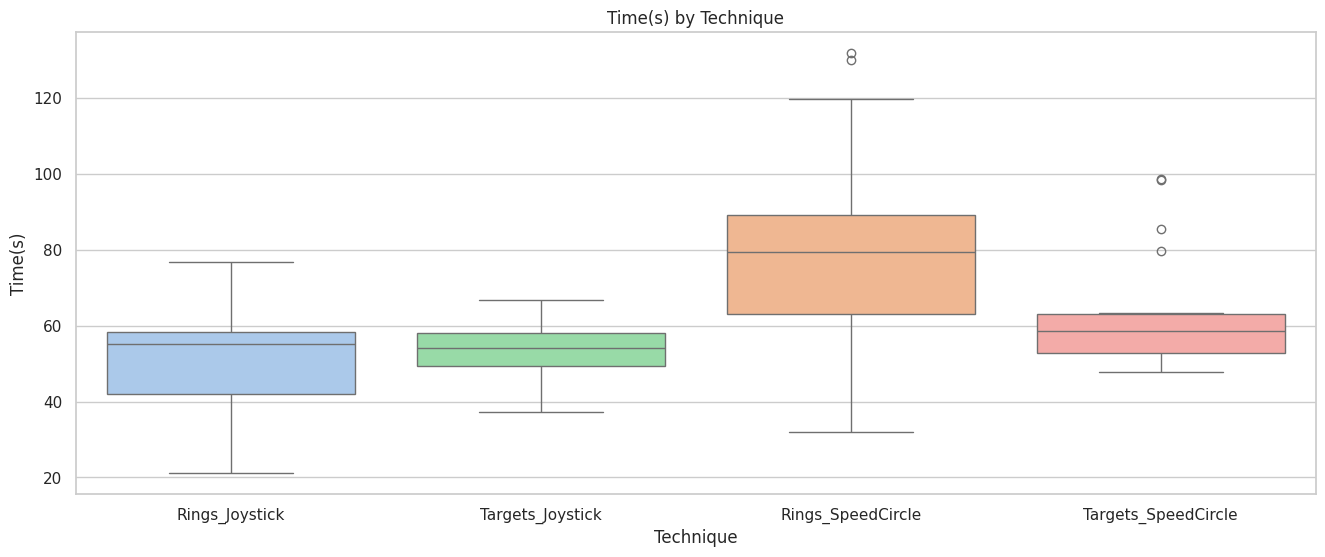

In [ ]:

order = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle']

# Create a color palette
palette = sns.color_palette("pastel", n_colors=len(experimental_data['Technique'].unique()))
order = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle']

# Velocity by Technique
plt.figure(figsize=(16, 6))
sns.boxplot(x='Technique', y='Time(s)', data=experimental_data, hue='Technique', order=order, palette=palette)
plt.xlabel('Technique')
plt.ylabel('Time(s)')
plt.title('Time(s) by Technique')
plt.show()



In [ ]:

experimental_data_cp = experimental_data[(experimental_data.Technique == 'Rings_Joystick') | (experimental_data.Technique == 'Rings_SpeedCircle')]
#rename 'Rings_Joystick' to Rings
experimental_data_cp['Technique'] = experimental_data_cp['Technique'].replace({'Rings_Joystick': 'Rings','Rings_SpeedCircle': 'Rings' })
experimental_data_cp

# fazer signicancia estatistica e comparar com o circle


<ipython-input-66-da0716887a29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experimental_data_cp['Technique'] = experimental_data_cp['Technique'].replace({'Rings_Joystick': 'Rings','Rings_SpeedCircle': 'Rings' })


,experiment_id,Cumulative_Distance,Time(s),numCollisions,Path_Length,Technique
0,02052024_160924,186.490854,29.989,1,392.890000,Rings
1,03052024_153111,192.739992,28.224,0,389.100000,Rings
2,03052024_163105,203.762724,42.479,0,399.300000,Rings
3,23042024_192840,174.903930,52.894,1,388.490000,Rings
4,23042024_201536,239.159193,61.874,2,516.860000,Rings
5,23042024_223411,190.615884,27.428,0,379.750000,Rings
6,24042024_185714,195.488943,54.915,0,428.270000,Rings
7,24042024_193528,193.908777,76.770,0,406.960000,Rings
8,24042024_204411,234.543485,55.571,1,496.660000,Rings
9,24042024_215631,223.024091,58.894,0,454.740000,Rings


In [ ]:
# get Daniel's data
%cd /content/drive/MyDrive/Colab_Notebooks/MagicCarpet

data_time_mc = pd.read_csv( os.getcwd() + "/2ndTest/time/timeRaw.csv")
data_time_mc['time'] = pd.to_numeric(data_time_mc['time'], errors='coerce')

# Drop any rows with missing values
data_time_mc.dropna(inplace=True)

# rename "user" to "experiment_id", "time" to "Time(s)" and "technique" to "Technique"
data_time_mc.rename(columns={'user': 'experiment_id', 'time': 'Time(s)', 'technique': 'Technique'}, inplace=True)

# rename value names of "AnalogSteering" to "Joystick_MC"
data_time_mc['Technique'] = data_time_mc['Technique'].replace({'AnalogSteering': 'Joystick_MC', "WalkingInPlace" : "WalkingInPlace_MC", "VirtualCircle" : "VirtualCircle_MC" })

data_time_mc.head()


/content/drive/MyDrive/Colab_Notebooks/MagicCarpet


,experiment_id,Technique,Time(s)
0,10minionMedex,Joystick_MC,60.02888
1,10minionMedex,VirtualCircle_MC,100.71330
2,10minionMedex,WalkingInPlace_MC,85.51553
3,11rafifa,Joystick_MC,57.87074
4,11rafifa,VirtualCircle_MC,86.40684


In [ ]:
experimental_data_time = experimental_data[["experiment_id", "Technique", "Time(s)"]]


In [ ]:
# combine experimental_data_time and magic_carpet_time into one dataframe
combined_time_df = pd.concat([experimental_data_time, data_time_mc], ignore_index=True)
print(combined_time_df.shape)
combined_time_df.head()


(128, 3)


,experiment_id,Technique,Time(s)
0,02052024_160924,Rings_Joystick,29.989
1,03052024_153111,Rings_Joystick,28.224
2,03052024_163105,Rings_Joystick,42.479
3,23042024_192840,Rings_Joystick,52.894
4,23042024_201536,Rings_Joystick,61.874


In [ ]:
groups = {
    'Rings_Joystick': combined_time_df[combined_time_df['Technique'] == 'Rings_Joystick']['Time(s)'],
    'Targets_Joystick': combined_time_df[combined_time_df['Technique'] == 'Targets_Joystick']['Time(s)'],
    'Rings_SpeedCircle': combined_time_df[combined_time_df['Technique'] == 'Rings_SpeedCircle']['Time(s)'],
    'Targets_SpeedCircle': combined_time_df[combined_time_df['Technique'] == 'Targets_SpeedCircle']['Time(s)'],
    'Joystick_MC': combined_time_df[combined_time_df['Technique'] == 'Joystick_MC']['Time(s)'],
    'VirtualCircle_MC': combined_time_df[combined_time_df['Technique'] == 'VirtualCircle_MC']['Time(s)'],
    'WalkingInPlace_MC': combined_time_df[combined_time_df['Technique'] == 'WalkingInPlace_MC']['Time(s)'],

}

In [ ]:
# Comparative Analysis using Kruskal-Wallis H test
stat_time, p_value_time = kruskal(groups['Rings_Joystick'],
                                  groups['Rings_SpeedCircle'],
                                  groups['Targets_Joystick'],
                                  groups['Targets_SpeedCircle'],
                                  groups['Joystick_MC'],
                                  groups['VirtualCircle_MC'],
                                  groups['WalkingInPlace_MC'])

print(f"Kruskal-Wallis H statistic: {stat_time}")
print(f"p-value: {p_value_time}")

# Dunn's Test for multiple comparisons
p_values = sp.posthoc_dunn([group for group in groups.values()], p_adjust='bonferroni')
p_values.rename(columns={1: 'Rings_Joystick', 3: 'Rings_SpeedCircle', 2: 'Targets_Joystick', 4:'Targets_SpeedCircle', 5 : "Joystick_MC", 6 : "VirtualCircle_MC", 7 : "WalkingInPlace_MC"}, inplace=True)
p_values.index = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle', 'Joystick_MC', 'VirtualCircle_MC', 'WalkingInPlace_MC' ]

cmap = sns.diverging_palette(133, 0, as_cmap=True)
p_values = p_values.style.applymap(color_significant).format("{:.4f}")
p_values


Kruskal-Wallis H statistic: 65.25477499572867
p-value: 3.826888433595012e-12


,Rings_Joystick,Targets_Joystick,Rings_SpeedCircle,Targets_SpeedCircle,Joystick_MC,VirtualCircle_MC,WalkingInPlace_MC
Rings_Joystick,1.0000,1.0000,0.0018,1.0000,0.4893,0.0000,0.0000
Targets_Joystick,1.0000,1.0000,0.0010,1.0000,0.3412,0.0000,0.0000
Rings_SpeedCircle,0.0018,0.0010,1.0000,0.5095,1.0000,0.7758,1.0000
Targets_SpeedCircle,1.0000,1.0000,0.5095,1.0000,1.0000,0.0004,0.0256
Joystick_MC,0.4893,0.3412,1.0000,1.0000,1.0000,0.0114,0.2470
VirtualCircle_MC,0.0000,0.0000,0.7758,0.0004,0.0114,1.0000,1.0000
WalkingInPlace_MC,0.0000,0.0000,1.0000,0.0256,0.2470,1.0000,1.0000


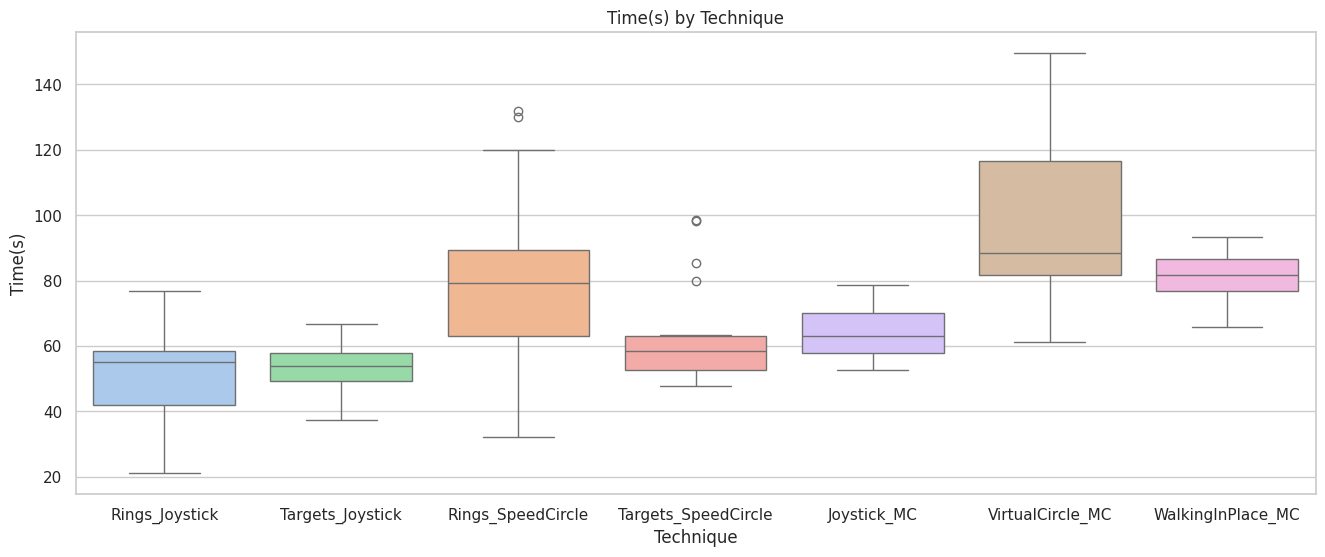

In [ ]:
# Create a color palette
palette = sns.color_palette("pastel", n_colors=len(combined_time_df['Technique'].unique()))
order = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle', 'Joystick_MC', "VirtualCircle_MC", "WalkingInPlace_MC"]

# Velocity by Technique
plt.figure(figsize=(16, 6))
sns.boxplot(x='Technique', y='Time(s)', data=combined_time_df, hue='Technique', order=order, palette=palette)
plt.xlabel('Technique')
plt.ylabel('Time(s)')
plt.title('Time(s) by Technique')
plt.show()


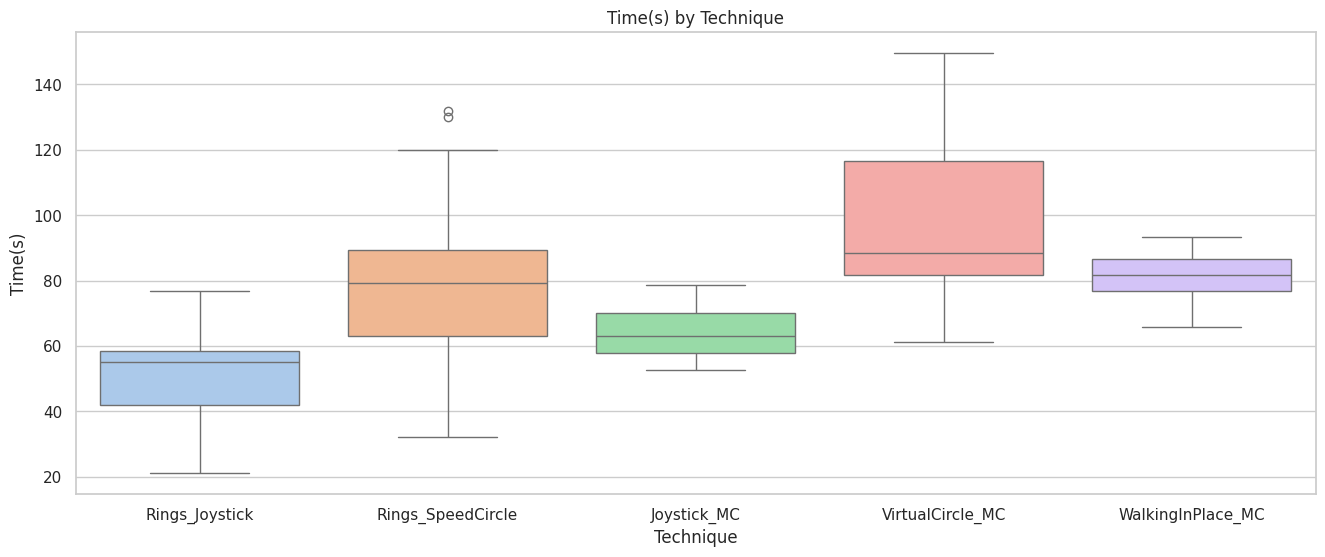

In [ ]:
# Create a color palette

combined_time_df_filtered = combined_time_df[(combined_time_df.Technique == 'Rings_Joystick') | (combined_time_df.Technique == 'Rings_SpeedCircle')| (combined_time_df.Technique == 'Joystick_MC') | (combined_time_df.Technique == 'VirtualCircle_MC') | (combined_time_df.Technique == 'WalkingInPlace_MC')]

palette = sns.color_palette("pastel", n_colors=len(combined_time_df_filtered['Technique'].unique()))
order = ['Rings_Joystick', 'Rings_SpeedCircle', 'Joystick_MC', "VirtualCircle_MC", "WalkingInPlace_MC"]

# Velocity by Technique
plt.figure(figsize=(16, 6))
sns.boxplot(x='Technique', y='Time(s)', data=combined_time_df_filtered, hue='Technique', order=order, palette=palette)
plt.xlabel('Technique')
plt.ylabel('Time(s)')
plt.title('Time(s) by Technique')
plt.show()


### Path Length

In [ ]:
outliers = experimental_data[experimental_data['Path_Length'] < 300]
outliers

,experiment_id,Cumulative_Distance,Time(s),numCollisions,Path_Length,Technique
18,29042024_153851,89.296455,21.162,0,150.310000,Rings_Joystick
66,24042024_185432,0.011048,0.388,0,0.012922,Targets_SpeedCircle


In [ ]:
experimental_data_path = experimental_data[["experiment_id", "Technique", "Path_Length"]]
experimental_data_path = experimental_data_path[experimental_data_path['Path_Length'] >= 300]
experimental_data_path

,experiment_id,Technique,Path_Length
0,02052024_160924,Rings_Joystick,392.890000
1,03052024_153111,Rings_Joystick,389.100000
2,03052024_163105,Rings_Joystick,399.300000
3,23042024_192840,Rings_Joystick,388.490000
4,23042024_201536,Rings_Joystick,516.860000
...,...,...,...
75,27042024_210212,Targets_SpeedCircle,384.898605
76,27042024_224017,Targets_SpeedCircle,514.555987
77,29042024_145409,Targets_SpeedCircle,394.663687
78,29042024_153455,Targets_SpeedCircle,443.322755


In [ ]:
groups = {
    'Rings_Joystick': experimental_data_path[experimental_data_path['Technique'] == 'Rings_Joystick']['Path_Length'],
    'Rings_SpeedCircle': experimental_data_path[experimental_data_path['Technique'] == 'Rings_SpeedCircle']['Path_Length'],
    'Targets_Joystick': experimental_data_path[experimental_data_path['Technique'] == 'Targets_Joystick']['Path_Length'],
    'Targets_SpeedCircle': experimental_data_path[experimental_data_path['Technique'] == 'Targets_SpeedCircle']['Path_Length']
}

In [ ]:
# Comparative Analysis using Kruskal-Wallis H test
stat_time, p_value_time = kruskal(groups['Rings_Joystick'],
                                  groups['Rings_SpeedCircle'],
                                  groups['Targets_Joystick'],
                                  groups['Targets_SpeedCircle'])

# Print the result of the statistical test
kruskal_test_time_result = {'Kruskal-Wallis H statistic': stat_time, 'p-value': p_value_time}
kruskal_test_time_result


{'Kruskal-Wallis H statistic': 6.31757802490651, 'p-value': 0.0971411718308682}

In [ ]:

# Dunn's Test for multiple comparisons
p_values = sp.posthoc_dunn([group for group in groups.values()], p_adjust='bonferroni')
p_values.rename(columns={1: 'Rings_Joystick', 3: 'Rings_SpeedCircle', 2: 'Targets_Joystick', 4:'Targets_SpeedCircle'}, inplace=True)
p_values.index = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle']

cmap = sns.diverging_palette(133, 0, as_cmap=True)
p_values = p_values.style.applymap(color_significant).format("{:.4f}")
p_values


,Rings_Joystick,Targets_Joystick,Rings_SpeedCircle,Targets_SpeedCircle
Rings_Joystick,1.0000,1.0000,0.7733,0.1270
Targets_Joystick,1.0000,1.0000,1.0000,0.4435
Rings_SpeedCircle,0.7733,1.0000,1.0000,1.0000
Targets_SpeedCircle,0.1270,0.4435,1.0000,1.0000


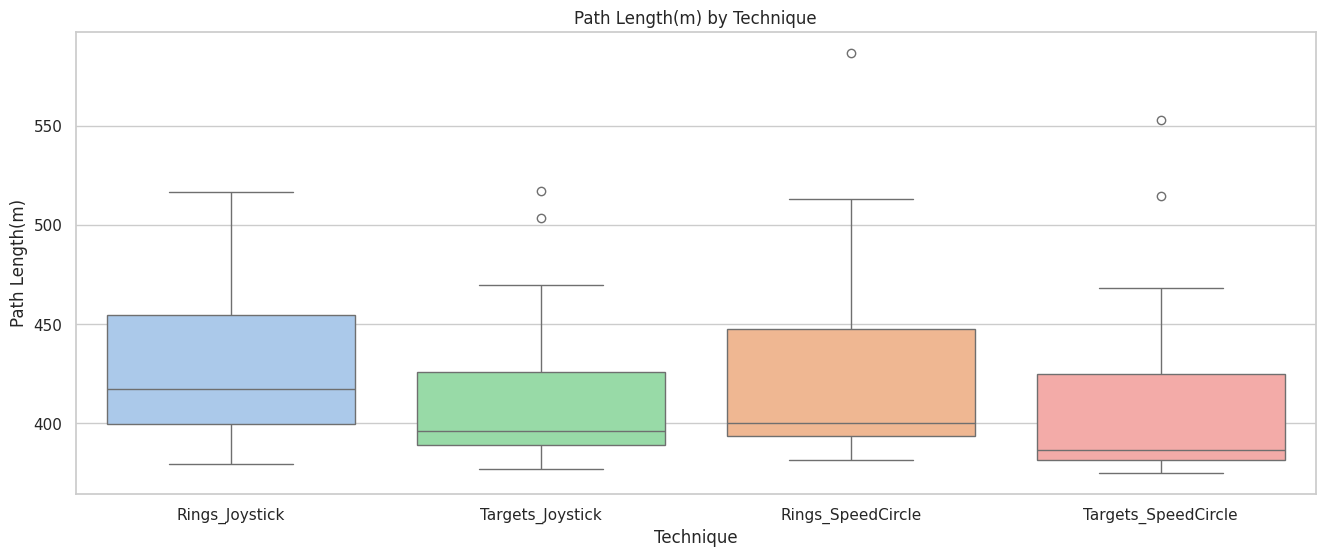

In [ ]:
# Create a color palette
palette = sns.color_palette("pastel", n_colors=len(experimental_data_path['Technique'].unique()))
order = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle']

# Velocity by Technique
plt.figure(figsize=(16, 6))
sns.boxplot(x='Technique', y='Path_Length', data=experimental_data_path, hue='Technique', order=order, palette=palette)
plt.xlabel('Technique')
plt.ylabel('Path Length(m)')
plt.title('Path Length(m) by Technique')
plt.show()


In [ ]:
# get Daniel's data
%cd /content/drive/MyDrive/Colab_Notebooks/MagicCarpet

pathlength_df = pd.read_csv( os.getcwd() + "/2ndTest/pathLength/pathLength.csv")
pathlength_df['length'] = pd.to_numeric(pathlength_df['length'], errors='coerce')

# Drop any rows with missing values
pathlength_df.dropna(inplace=True)

# rename "user" to "experiment_id", "time" to "Time(s)" and "technique" to "Technique"
pathlength_df.rename(columns={'user': 'experiment_id', 'length': 'Path_Length', 'technique': 'Technique'}, inplace=True)

# rename value names of "AnalogSteering" to "Joystick_MC"
pathlength_df['Technique'] = pathlength_df['Technique'].replace({'AnalogSteering': 'Joystick_MC', "WalkingInPlace" : "WalkingInPlace_MC", "VirtualCircle" : "VirtualCircle_MC" })

pathlength_df.head()


/content/drive/MyDrive/Colab_Notebooks/MagicCarpet


,experiment_id,Technique,Path_Length
1,10minionMedex,Joystick_MC,481.4468
2,10minionMedex,WalkingInPlace_MC,485.9280
3,11rafifa,Joystick_MC,483.5557
4,11rafifa,VirtualCircle_MC,508.1756
5,11rafifa,WalkingInPlace_MC,496.0159


In [ ]:
experimental_data_path = experimental_data[["experiment_id", "Technique", "Path_Length"]]


In [ ]:
# combine experimental_data_time and magic_carpet_time into one dataframe
combined_path_df = pd.concat([experimental_data_path, pathlength_df], ignore_index=True)
print(combined_path_df.shape)
combined_path_df.head()

(130, 3)


,experiment_id,Technique,Path_Length
0,02052024_160924,Rings_Joystick,392.89
1,03052024_153111,Rings_Joystick,389.10
2,03052024_163105,Rings_Joystick,399.30
3,23042024_192840,Rings_Joystick,388.49
4,23042024_201536,Rings_Joystick,516.86


In [ ]:
combined_path_df = combined_path_df[combined_path_df['Path_Length'] >= 300]

In [ ]:
groups = {
    'Rings_Joystick': combined_path_df[combined_path_df['Technique'] == 'Rings_Joystick']['Path_Length'],
    'Targets_Joystick': combined_path_df[combined_path_df['Technique'] == 'Targets_Joystick']['Path_Length'],
    'Rings_SpeedCircle': combined_path_df[combined_path_df['Technique'] == 'Rings_SpeedCircle']['Path_Length'],
    'Targets_SpeedCircle': combined_path_df[combined_path_df['Technique'] == 'Targets_SpeedCircle']['Path_Length'],
    'Joystick_MC': combined_path_df[combined_path_df['Technique'] == 'Joystick_MC']['Path_Length'],
    'VirtualCircle_MC': combined_path_df[combined_path_df['Technique'] == 'VirtualCircle_MC']['Path_Length'],
    'WalkingInPlace_MC': combined_path_df[combined_path_df['Technique'] == 'WalkingInPlace_MC']['Path_Length'],
}

In [ ]:
# Comparative Analysis using Kruskal-Wallis H test
stat_time, p_value_time = kruskal(groups['Rings_Joystick'],
                                  groups['Rings_SpeedCircle'],
                                  groups['Targets_Joystick'],
                                  groups['Targets_SpeedCircle'],
                                  groups['Joystick_MC'],
                                  groups['VirtualCircle_MC'],
                                  groups['WalkingInPlace_MC'])

print(f"Kruskal-Wallis H statistic: {stat_time}")
print(f"p-value: {p_value_time}")

# Dunn's Test for multiple comparisons
p_values = sp.posthoc_dunn([group for group in groups.values()], p_adjust='bonferroni')
p_values.rename(columns={1: 'Rings_Joystick', 3: 'Rings_SpeedCircle', 2: 'Targets_Joystick', 4:'Targets_SpeedCircle', 5 : "Joystick_MC", 6 : "VirtualCircle_MC", 7 : "WalkingInPlace_MC"}, inplace=True)
p_values.index = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle', 'Joystick_MC', 'VirtualCircle_MC', 'WalkingInPlace_MC' ]

cmap = sns.diverging_palette(133, 0, as_cmap=True)
p_values = p_values.style.applymap(color_significant).format("{:.4f}")
p_values


Kruskal-Wallis H statistic: 59.50716338019299
p-value: 5.667662919864036e-11


,Rings_Joystick,Targets_Joystick,Rings_SpeedCircle,Targets_SpeedCircle,Joystick_MC,VirtualCircle_MC,WalkingInPlace_MC
Rings_Joystick,1.0000,1.0000,1.0000,1.0000,0.7339,0.0017,0.0052
Targets_Joystick,1.0000,1.0000,1.0000,1.0000,0.0300,0.0000,0.0000
Rings_SpeedCircle,1.0000,1.0000,1.0000,1.0000,0.3482,0.0004,0.0015
Targets_SpeedCircle,1.0000,1.0000,1.0000,1.0000,0.0072,0.0000,0.0000
Joystick_MC,0.7339,0.0300,0.3482,0.0072,1.0000,1.0000,1.0000
VirtualCircle_MC,0.0017,0.0000,0.0004,0.0000,1.0000,1.0000,1.0000
WalkingInPlace_MC,0.0052,0.0000,0.0015,0.0000,1.0000,1.0000,1.0000


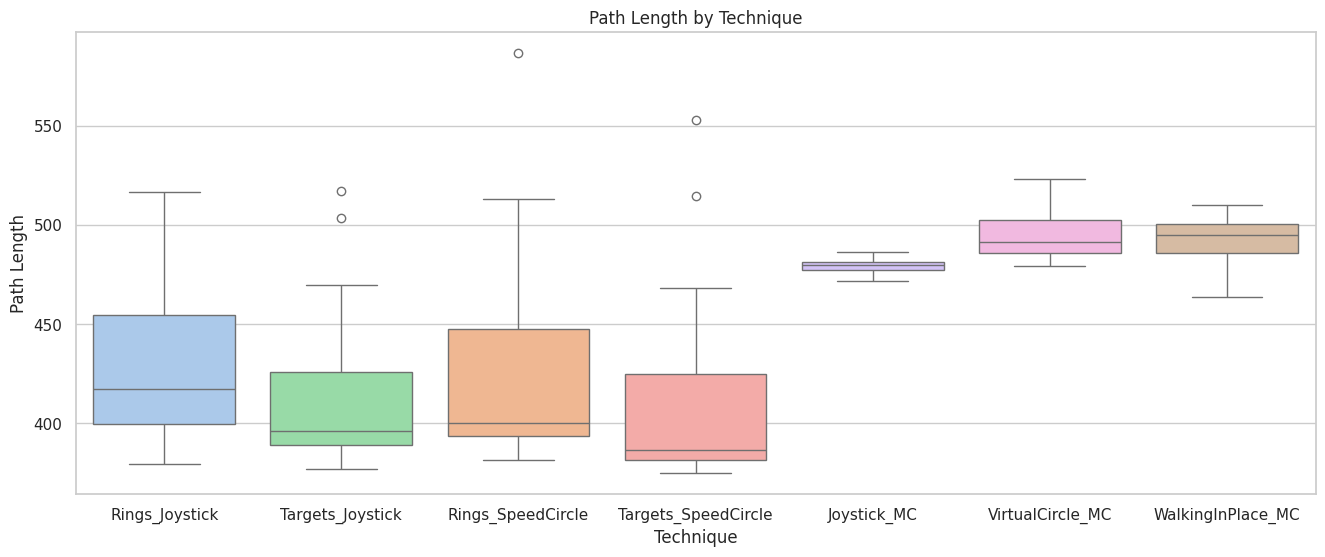

In [ ]:
# Create a color palette
palette = sns.color_palette("pastel", n_colors=len(combined_path_df['Technique'].unique()))
order = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle', 'Joystick_MC', "VirtualCircle_MC", "WalkingInPlace_MC"]

# Velocity by Technique
plt.figure(figsize=(16, 6))
sns.boxplot(x='Technique', y='Path_Length', data=combined_path_df, hue='Technique', order=order, palette=palette)
plt.xlabel('Technique')
plt.ylabel('Path Length')
plt.title('Path Length by Technique')
plt.show()


- todo:
- nothing here

#### Collisions

In [ ]:
experimental_data_collisions = experimental_data[["experiment_id", "Technique", "numCollisions"]]
experimental_data_collisions

In [ ]:
groups = {
    'Rings_Joystick': experimental_data_collisions[experimental_data_collisions['Technique'] == 'Rings_Joystick']['numCollisions'],
    'Targets_Joystick': experimental_data_collisions[experimental_data_collisions['Technique'] == 'Targets_Joystick']['numCollisions'],
    'Rings_SpeedCircle': experimental_data_collisions[experimental_data_collisions['Technique'] == 'Rings_SpeedCircle']['numCollisions'],
    'Targets_SpeedCircle': experimental_data_collisions[experimental_data_collisions['Technique'] == 'Targets_SpeedCircle']['numCollisions']
}

In [ ]:
# Comparative Analysis using Kruskal-Wallis H test
stat_path, p_value_path = kruskal(groups['Rings_Joystick'],
                                  groups['Rings_SpeedCircle'],
                                  groups['Targets_Joystick'],
                                  groups['Targets_SpeedCircle'])

# Print the result of the statistical test
kruskal_test_path_result = {'Kruskal-Wallis H statistic': stat_path, 'p-value': p_value_path}
kruskal_test_path_result


{'Kruskal-Wallis H statistic': 11.688210368274774,
 'p-value': 0.008531235915865796}

In [ ]:
import pandas as pd
from scipy import stats
import scikit_posthocs as sp

# Dunn's Test for multiple comparisons
p_values = sp.posthoc_dunn([group for group in groups.values()], p_adjust='bonferroni')
p_values.rename(columns={1: 'Rings_Joystick', 3: 'Rings_SpeedCircle', 2: 'Targets_Joystick', 4:'Targets_SpeedCircle'}, inplace=True)
p_values.index = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle']

cmap = sns.diverging_palette(133, 0, as_cmap=True)
p_values = p_values.style.applymap(color_significant).format("{:.4f}")
p_values


,Rings_Joystick,Targets_Joystick,Rings_SpeedCircle,Targets_SpeedCircle
Rings_Joystick,1.0000,0.1195,1.0000,0.1088
Targets_Joystick,0.1195,1.0000,0.0816,1.0000
Rings_SpeedCircle,1.0000,0.0816,1.0000,0.0739
Targets_SpeedCircle,0.1088,1.0000,0.0739,1.0000


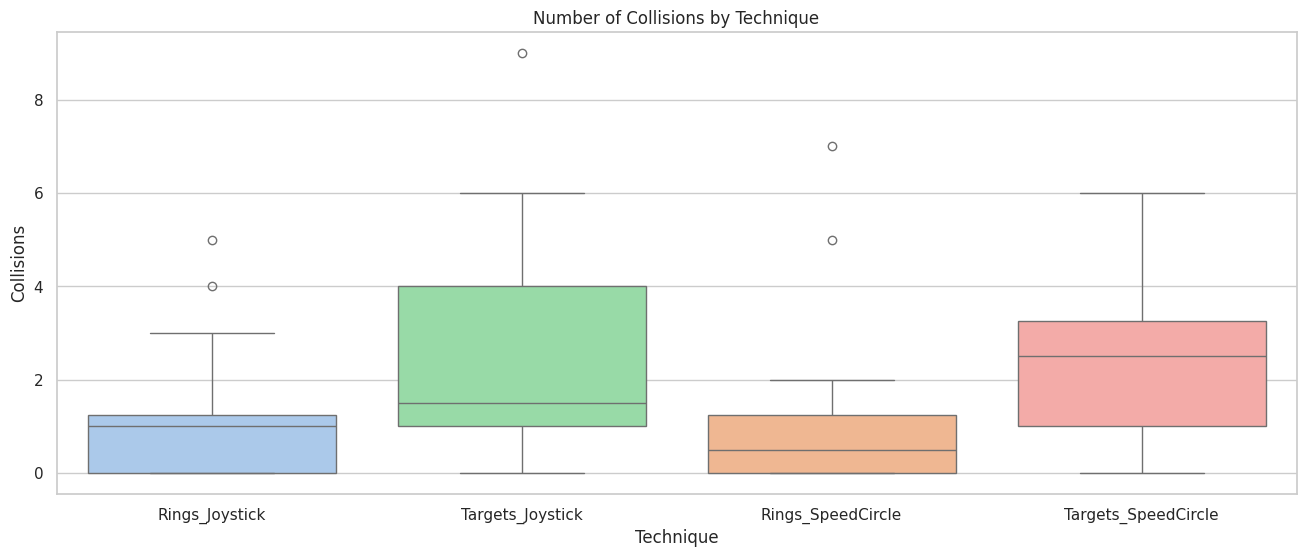

In [ ]:
# Create a color palette
palette = sns.color_palette("pastel", n_colors=len(experimental_data_collisions['Technique'].unique()))
order = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle']

# Velocity by Technique
plt.figure(figsize=(16, 6))
sns.boxplot(x='Technique', y='numCollisions', data=experimental_data_collisions, hue='Technique', order=order, palette=palette)
plt.xlabel('Technique')
plt.ylabel('Collisions')
plt.title('Number of Collisions by Technique')
plt.show()


In [ ]:
# get Daniel's data
%cd /content/drive/MyDrive/Colab_Notebooks/MagicCarpet

collisions_df = pd.read_csv( os.getcwd() + "/2ndTest/collision/colision.csv")

# drop columns 'joysticktimeCol', 'circletimeCol', 'wiptimeCol'
collisions_df = collisions_df.drop(['joysticktimeCol', 'circletimeCol', 'wiptimeCol'], axis=1)

# Convert collision columns to numeric
collisions_df['joysticknCol'] = pd.to_numeric(collisions_df['joysticknCol'], errors='coerce')
collisions_df['circlenCol'] = pd.to_numeric(collisions_df['circlenCol'], errors='coerce')
collisions_df['wipnCol'] = pd.to_numeric(collisions_df['wipnCol'], errors='coerce')

# Drop any rows with missing values
collisions_df.dropna(inplace=True)


/content/drive/MyDrive/Colab_Notebooks/MagicCarpet


In [ ]:

# Initialize an empty list to store the transformed data
collisions_df_transf = []

# Iterate over each row in the original dataframe
for idx, row in collisions_df.iterrows():
    experiment_id = idx + 1  # Assuming experiment_id starts from 1 and increments by 1 for each row
    collisions_df_transf.append([experiment_id, 'joystick', row['joysticknCol']])
    collisions_df_transf.append([experiment_id, 'circle', row['circlenCol']])
    collisions_df_transf.append([experiment_id, 'wip', row['wipnCol']])

# Create a new dataframe from the transformed data
transformed_df = pd.DataFrame(collisions_df_transf, columns=['experiment_id', 'Technique', 'numCollisions'])
transformed_df["experiment_id"] = transformed_df.index
transformed_df



In [ ]:
# rename value names of "AnalogSteering" to "Joystick_MC"
transformed_df['Technique'] = transformed_df['Technique'].replace({'joystick': 'Joystick_MC', "wip" : "WalkingInPlace_MC", "circle" : "VirtualCircle_MC" })
transformed_df.head()


,experiment_id,Technique,numCollisions
0,0,Joystick_MC,1.0
1,1,VirtualCircle_MC,1.0
2,2,WalkingInPlace_MC,3.0
3,3,Joystick_MC,2.0
4,4,VirtualCircle_MC,3.0


In [ ]:
experimental_data_colisions = experimental_data[["experiment_id", "Technique", "numCollisions"]]


In [ ]:
# combine experimental_data_time and magic_carpet_time into one dataframe
combined_collisions_df = pd.concat([experimental_data_colisions, transformed_df], ignore_index=True)
print(combined_collisions_df.shape)
combined_collisions_df.head()

(131, 3)


,experiment_id,Technique,numCollisions
0,02052024_160924,Rings_Joystick,1.0
1,03052024_153111,Rings_Joystick,0.0
2,03052024_163105,Rings_Joystick,0.0
3,23042024_192840,Rings_Joystick,1.0
4,23042024_201536,Rings_Joystick,2.0


In [ ]:
groups = {
    'Rings_Joystick': combined_collisions_df[combined_collisions_df['Technique'] == 'Rings_Joystick']['numCollisions'],
    'Targets_Joystick': combined_collisions_df[combined_collisions_df['Technique'] == 'Targets_Joystick']['numCollisions'],
    'Rings_SpeedCircle': combined_collisions_df[combined_collisions_df['Technique'] == 'Rings_SpeedCircle']['numCollisions'],
    'Targets_SpeedCircle': combined_collisions_df[combined_collisions_df['Technique'] == 'Targets_SpeedCircle']['numCollisions'],
    'Joystick_MC': combined_collisions_df[combined_collisions_df['Technique'] == 'Joystick_MC']['numCollisions'],
    'VirtualCircle_MC': combined_collisions_df[combined_collisions_df['Technique'] == 'VirtualCircle_MC']['numCollisions'],
    'WalkingInPlace_MC': combined_collisions_df[combined_collisions_df['Technique'] == 'WalkingInPlace_MC']['numCollisions'],
}

In [ ]:
# Comparative Analysis using Kruskal-Wallis H test
stat_time, p_value_time = kruskal(groups['Rings_Joystick'],
                                  groups['Rings_SpeedCircle'],
                                  groups['Targets_Joystick'],
                                  groups['Targets_SpeedCircle'],
                                  groups['Joystick_MC'],
                                  groups['VirtualCircle_MC'],
                                  groups['WalkingInPlace_MC'])

print(f"Kruskal-Wallis H statistic: {stat_time}")
print(f"p-value: {p_value_time}")

# Dunn's Test for multiple comparisons
p_values = sp.posthoc_dunn([group for group in groups.values()], p_adjust='bonferroni')
p_values.rename(columns={1: 'Rings_Joystick', 3: 'Rings_SpeedCircle', 2: 'Targets_Joystick', 4:'Targets_SpeedCircle', 5 : "Joystick_MC", 6 : "VirtualCircle_MC", 7 : "WalkingInPlace_MC"}, inplace=True)
p_values.index = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle', 'Joystick_MC', 'VirtualCircle_MC', 'WalkingInPlace_MC' ]

cmap = sns.diverging_palette(133, 0, as_cmap=True)
p_values = p_values.style.applymap(color_significant).format("{:.4f}")
p_values


Kruskal-Wallis H statistic: 29.9906971845474
p-value: 3.946884485619307e-05


,Rings_Joystick,Targets_Joystick,Rings_SpeedCircle,Targets_SpeedCircle,Joystick_MC,VirtualCircle_MC,WalkingInPlace_MC
Rings_Joystick,1.0000,0.2170,1.0000,0.1254,1.0000,0.0101,0.0056
Targets_Joystick,0.2170,1.0000,0.1304,1.0000,1.0000,1.0000,1.0000
Rings_SpeedCircle,1.0000,0.1304,1.0000,0.0731,1.0000,0.0054,0.0029
Targets_SpeedCircle,0.1254,1.0000,0.0731,1.0000,1.0000,1.0000,1.0000
Joystick_MC,1.0000,1.0000,1.0000,1.0000,1.0000,0.6829,0.4678
VirtualCircle_MC,0.0101,1.0000,0.0054,1.0000,0.6829,1.0000,1.0000
WalkingInPlace_MC,0.0056,1.0000,0.0029,1.0000,0.4678,1.0000,1.0000


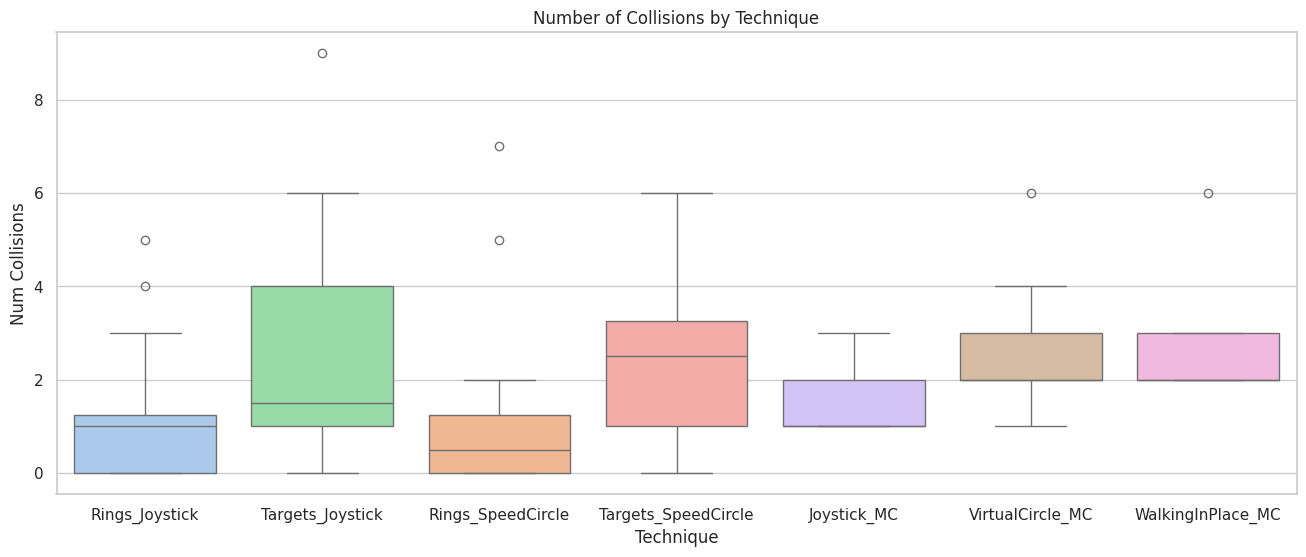

In [ ]:
# Create a color palette
palette = sns.color_palette("pastel", n_colors=len(combined_collisions_df['Technique'].unique()))
order = ['Rings_Joystick', 'Targets_Joystick', 'Rings_SpeedCircle', 'Targets_SpeedCircle', 'Joystick_MC', "VirtualCircle_MC", "WalkingInPlace_MC"]

# Velocity by Technique
plt.figure(figsize=(16, 6))
sns.boxplot(x='Technique', y='numCollisions', data=combined_collisions_df, hue='Technique', order=order, palette=palette)
plt.xlabel('Technique')
plt.ylabel('Num Collisions')
plt.title('Number of Collisions by Technique')
plt.show()


- 1 * por cada zero